US/China/etc: https://github.com/ranaroussi/yfinance

Russia stocks: https://github.com/Tinkoff/invest-python/tree/main

Russia index: https://github.com/ffeast/finam-export/tree/master and its edit https://github.com/am1ter/finam-export/tree/master

In [1]:
from tinkoff.invest import CandleInterval, Client
from tinkoff.invest.caching.market_data_cache.cache_settings import (
    MarketDataCacheSettings,
)
from tinkoff.invest.services import MarketDataCache
from tinkoff.invest.utils import now

import yfinance as yf
from finam import Exporter, Market, LookupComparator
IMOEX_IDX = 13851

from dataclasses import dataclass, asdict
from functools import lru_cache
from IPython.display import display
from pathlib import Path
from PIL import Image
import datetime
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import scipy.stats as sps
import seaborn as sns
import tqdm

with open('./tcs_token.txt', 'r') as inf:
    TOKEN = inf.read().strip()

with Client(TOKEN) as client:
    print(client.users.get_accounts())

GetAccountsResponse(accounts=[Account(id='2008799645', type=<AccountType.ACCOUNT_TYPE_TINKOFF: 1>, name='Финтеханализ RUB', status=<AccountStatus.ACCOUNT_STATUS_OPEN: 2>, opened_date=datetime.datetime(2023, 1, 2, 0, 0, tzinfo=datetime.timezone.utc), closed_date=datetime.datetime(1970, 1, 1, 0, 0, tzinfo=datetime.timezone.utc), access_level=<AccessLevel.ACCOUNT_ACCESS_LEVEL_READ_ONLY: 2>)])


In [2]:
def q2n(q):
    return (q.units + q.nano * 10**-9) if not isinstance(q, dict) else (q['units'] + q['nano'] * 10**-9)

def candle_list_to_df(candles, remove_incomplete=True):
    df = pd.DataFrame(
        [[
            c.time,
            q2n(c.open),
            q2n(c.high),
            q2n(c.low),
            q2n(c.close),
            c.volume
         ] for c in candles if (not remove_incomplete or c.is_complete)],
        columns=['date', 'Open', 'High', 'Low', 'Close', 'Volume']
    )
    df['date'] = pd.to_datetime(df['date']).dt.tz_localize(None).dt.floor('1D')
    df.set_index('date', inplace=True)
    return df[df.index.weekday < 5].groupby(level=0).agg({'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last', 'Volume': 'sum'})

def load_tcs_data(ticker, from_, adj_div=True, enforce_today=False, remove_incomplete=True):
    with Client(TOKEN) as client:
        r = client.instruments.find_instrument(query=ticker)
        figis = []
        for i in r.instruments:
            if ((ticker == 'IMOEX' and i.ticker == 'IMOEX') or 
                ((not ticker.isdigit()) and i.instrument_type == 'share' and i.class_code == 'TQBR' and i.ticker == ticker) or
                (ticker.isdigit() and i.instrument_type == 'share' and i.class_code == 'SPBHKEX' and i.ticker == ticker)):
                figis.append(i.figi)
        if len(figis) != 1:
            raise ValueError(f'Error mapping a ticker to figi, {len(figis)}')
        else:
            figi = figis[0]
        
        settings = MarketDataCacheSettings(base_cache_dir=Path("market_data_cache1"))
        market_data_cache = MarketDataCache(settings=settings, services=client)
        
        candles = []
        for candle in market_data_cache.get_all_candles(
            figi=figi,
            from_=from_,
            interval=CandleInterval.CANDLE_INTERVAL_DAY,
        ):
            candles.append(candle)
        candle_df = candle_list_to_df(candles, remove_incomplete)
        if enforce_today:
            for candle in market_data_cache.get_all_candles(
                figi=figi,
                from_=now() - max(datetime.timedelta(days=7), datetime.datetime.now() - candle_df.index.max()),
                interval=CandleInterval.CANDLE_INTERVAL_1_MIN,
            ):
                candles.append(candle)
            new_candle_df = candle_list_to_df(candles, remove_incomplete)
            candle_df = pd.concat([
                candle_df,
                new_candle_df[~(new_candle_df.index.isin(candle_df.index))
                              & (new_candle_df.index < new_candle_df.index.max())]
            ]).sort_index()
        
        if adj_div:
            df = pd.DataFrame([asdict(x) for x in client.instruments.get_dividends(figi=figi, from_=from_, to=now()).dividends])
            if df.empty:
                div_dct = {}
            else:
                df['yield_value'] = df['yield_value'].apply(q2n)
                df['last_buy_date'] = df['last_buy_date'].dt.tz_localize(None).dt.floor('1D')
                df = df[(pd.to_datetime(df.payment_date).dt.tz_localize(None) > pd.to_datetime(0)) &
                                       (df.dividend_type != 'Cancelled')]
                df = df[['yield_value', 'last_buy_date']].groupby('last_buy_date')['yield_value'].sum()
                div_dct = df.to_dict()
            for ex_date, yield_rate in sorted(div_dct.items()):
                candle_df.loc[candle_df.index <= ex_date, ['Open', 'High', 'Low', 'Close']] *= (1 - yield_rate / 100)
    return candle_df

In [3]:
@lru_cache()
def get_market_index(market='ru', int_days=None):
    if int_days is None:
        start = datetime.date(2018, 1, 1)
    else:
        start = datetime.date.today() - datetime.timedelta(days=int_days)
    if market == 'ru':
        exporter = Exporter()
        data = exporter.download(IMOEX_IDX, market=Market.INDEXES, start_date=start)
        data.columns = ['Date', 'Time', 'Open', 'High', 'Low', 'Close', 'Volume']
        data['Date'] = pd.to_datetime(data['Date'], format='%Y%m%d')
        data.drop('Time', axis=1, inplace=True)
        data.set_index('Date', inplace=True)
        return data['Close']
    elif market == 'us':
        data = yf.download('^GSPC', start=start)
        return data['Close']
    elif market == 'hk':
        data = yf.download('^HSI', start=start, progress=False)
        return data['Close']
    else:
        raise ValueError(f'Unknown market "{market}"')

@lru_cache()
def get_stock(ticker, market='ru', int_days=5*365):
    if market == 'ru':
        data = load_tcs_data(ticker, now() - datetime.timedelta(days=int_days), adj_div=True)
        return data['Close']
    elif market == 'us':
        data = yf.download(ticker, start=datetime.date.today()-datetime.timedelta(days=int_days))
        return data['Adj Close']
    elif market == 'hk':
        data = yf.download(f'{int(ticker):04}.HK', start=datetime.date.today()-datetime.timedelta(days=int_days), progress=False)
        return data['Adj Close']
    else:
        raise ValueError(f'Unknown market "{market}"')
        
def calculate_stats(index, index_name, stocks, stocks_names, weights, n_days=252):
    index_r = np.log(index).diff(1).dropna().values
    stocks_rs = [np.log(st).diff(1).dropna().values for st in stocks]
    
    betas = [sps.linregress(index_r, st_r).slope for st_r in stocks_rs]
    returns = [st_r.mean() * n_days for st_r in stocks_rs]
    vols = [st_r.std(ddof=1) * np.sqrt(n_days) for st_r in stocks_rs]
    print('Статистика по акциям:')
    display(
        pd.DataFrame({'Акция': stocks_names, 'Бета': betas, 'Доходность': returns,
                      'Волатильность': vols, 'Вес': weights}).set_index('Акция')
    )
    print('Корреляция доходностей:')
    c = pd.DataFrame(stocks_rs).T
    c.columns = stocks_names
    display(c.corr())
    
    p_ret = np.array(weights) @ returns
    p_vol = np.sqrt(np.array(weights) @ (c.cov(ddof=1) @ np.array(weights)) * n_days)
    print('Сравнение с индексным портфелем:')
    display(
        pd.DataFrame(
            [[index_r.mean() * n_days, p_ret],
             [index_r.std(ddof=1) * np.sqrt(n_days), p_vol],
             [1.0, np.array(betas) @ weights],
             [index_r.mean() * np.sqrt(n_days) / index_r.std(ddof=1), p_ret/p_vol]],
            columns=[index_name, 'Портфель'],
            index=['Доходность', 'Волатильность', 'Бета', 'Коэф. Шарпа']
        )
    )

INDEX_NAMES = {'ru': 'IMOEX', 'hk': 'HSI', 'us': 'SP500'}
def calculate_stats_for_stocks(market, stocks, weights, int_days=5*365):
    index_d = get_market_index(market, int_days)
    stocks_d = [get_stock(t, market, int_days) for t in stocks]
    
    date_set = set(index_d.index)
    for st in stocks_d:
        date_set = date_set.intersection(set(st.index))
    index_d = index_d[index_d.index.isin(date_set)]
    stocks_d = [st[st.index.isin(date_set)] for st in stocks_d]
    
    weights = [w/sum(weights) for w in weights]
    
    print(f'{len(date_set)} дней с {index_d.index[0].date()} по {index_d.index[-1].date()}')
    calculate_stats(index_d, INDEX_NAMES[market], stocks_d, stocks, weights)
    return index_d, stocks_d

In [163]:
_ = calculate_stats_for_stocks('ru', ['FIVE', 'LKOH', 'MAGN', 'AGRO', 'SBER'], [8600, 6500, 8700, 9900, 10100])

1237 дней с 2018-09-26 по 2023-09-22
Статистика по акциям:


,Бета,Доходность,Волатильность,Вес
Акция,,,,
FIVE,0.732778,0.097467,0.399645,0.196347
LKOH,0.881689,0.164081,0.352801,0.148402
MAGN,0.604629,0.088173,0.336794,0.198630
AGRO,0.593896,0.149425,0.336276,0.226027
SBER,1.099271,0.117935,0.403936,0.230594


Корреляция доходностей:


,FIVE,LKOH,MAGN,AGRO,SBER
FIVE,1.000000,0.435707,0.424742,0.446930,0.521214
LKOH,0.435707,1.000000,0.437997,0.417451,0.626628
MAGN,0.424742,0.437997,1.000000,0.340497,0.512194
AGRO,0.446930,0.417451,0.340497,1.000000,0.442888
SBER,0.521214,0.626628,0.512194,0.442888,1.000000


Сравнение с индексным портфелем:


,IMOEX,Портфель
Доходность,0.046498,0.121970
Волатильность,0.300213,0.278273
Бета,1.000000,0.782542
Коэф. Шарпа,0.154883,0.438311


In [4]:
_ = calculate_stats_for_stocks('hk', ['1299', '9888', '3988', '0857', '0700', '0288'], [660, 1300, 1660, 1740, 2190, 1660])

616 дней с 2021-03-23 по 2023-09-22
Статистика по акциям:


,Бета,Доходность,Волатильность,Вес
Акция,,,,
1299,0.868269,-0.134429,0.313743,0.071661
9888,1.750966,-0.272478,0.585323,0.141151
3988,0.350598,0.079288,0.157197,0.180239
0857,0.503867,0.401088,0.311978,0.188925
0700,1.414707,-0.278927,0.441417,0.237785
0288,0.629400,-0.159753,0.321198,0.180239


Корреляция доходностей:


,1299,9888,3988,0857,0700,0288
1299,1.000000,0.485449,0.493268,0.298512,0.482516,0.412204
9888,0.485449,1.000000,0.354302,0.319628,0.727142,0.369554
3988,0.493268,0.354302,1.000000,0.414284,0.300371,0.417640
0857,0.298512,0.319628,0.414284,1.000000,0.258128,0.270832
0700,0.482516,0.727142,0.300371,0.258128,1.000000,0.350588
0288,0.412204,0.369554,0.417640,0.270832,0.350588,1.000000


Сравнение с индексным портфелем:


,HSI,Портфель
Доходность,-0.186953,-0.053146
Волатильность,0.260302,0.259445
Бета,1.000000,0.917595
Коэф. Шарпа,-0.718216,-0.204845


In [160]:
exc = pd.read_excel('C:/Users/vbifk/Downloads/Volatilnost (1).xlsx')
index = exc.iloc[:, 1]
stocks = [exc.iloc[:, i] for i in (2, 3)]
stocks_names = ['GE', 'Vertex']
calculate_stats(index, 'SP500', stocks, stocks_names, [0.2, 0.8])

Статистика по акциям:


,Бета,Доходность,Волатильность,Вес
Акция,,,,
GE,1.183172,-0.242245,0.437752,0.2
Vertex,0.937303,0.287884,0.367733,0.8


Корреляция доходностей:


,GE,Vertex
GE,1.000000,0.207099
Vertex,0.207099,1.000000


Сравнение с индексным портфелем:


,SP500,Портфель
Доходность,0.127495,0.181858
Волатильность,0.206132,0.323850
Бета,1.000000,0.986477
Коэф. Шарпа,0.618512,0.561551


In [91]:
stocks_rs = [np.log(st).diff(1).dropna().values for st in stocks]
c = pd.DataFrame(stocks_rs).T
c.columns = stocks_names
display(c.corr())
display(c.cov())

,GE,Vertex
GE,1.000000,0.207099
Vertex,0.207099,1.000000


,GE,Vertex
GE,0.000760,0.000132
Vertex,0.000132,0.000537


In [95]:
0.437752 * 0.437752  / 252

0.0007604238631111111

In [90]:
[1, 2, 3] @ (np.array([[1, 2, 3], [3, 4, 5], [6, 7, 8]]) @ [1, 2, 3])

198

In [127]:
get_market_index(int_days=365)

Date
2022-09-26    1933.35
2022-09-27    1953.46
2022-09-28    1963.86
2022-09-29    1953.77
2022-09-30    1957.31
               ...   
2023-09-18    3135.18
2023-09-19    3083.85
2023-09-20    3068.15
2023-09-21    3019.22
2023-09-22    3049.07
Name: Close, Length: 253, dtype: float64

In [68]:
st.linregress([1, 2, 3], [2, 4, 6]).slope

2.0

In [55]:
get_stock('LKOH')

date
2018-09-26    2904.482086
2018-09-27    2978.770900
2018-09-28    3020.877920
2018-10-01    3017.268746
2018-10-02    2946.589106
                 ...     
2023-09-18    6526.000000
2023-09-19    6344.000000
2023-09-20    6423.000000
2023-09-21    6379.000000
2023-09-22    6495.000000
Name: Close, Length: 1249, dtype: float64

In [56]:
get_stock('AAPL', 'us')

[*********************100%%**********************]  1 of 1 completed


Date
2018-09-25     53.199711
2018-09-26     52.775913
2018-09-27     53.860546
2018-09-28     54.049706
2018-10-01     54.413639
                 ...    
2023-09-18    177.970001
2023-09-19    179.070007
2023-09-20    175.490005
2023-09-21    173.929993
2023-09-22    174.789993
Name: Adj Close, Length: 1257, dtype: float64

In [57]:
get_stock('857', 'hk')

[*********************100%%**********************]  1 of 1 completed


Date
2018-09-26    4.404148
2018-09-27    4.376051
2018-09-28    4.453317
2018-10-02    4.446292
2018-10-03    4.537607
                ...   
2023-09-18    5.750000
2023-09-19    5.740000
2023-09-20    5.810000
2023-09-21    5.770000
2023-09-22    5.810000
Name: Adj Close, Length: 1229, dtype: float64

In [44]:
st = '0857'
print()

0857.HK


In [38]:
f'{3:02}'

'03'

In [ ]:
yf.

In [28]:
datetime.date.today() - datetime.timedelta(days=365)

datetime.date(2022, 9, 24)

In [27]:
yf.download('0857.HK')

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-04-07,1.27,1.28,1.17,1.21,0.399088,716230000
2000-04-10,1.21,1.23,1.18,1.23,0.405684,88238000
2000-04-11,1.21,1.33,1.21,1.29,0.425474,338852000
2000-04-12,1.30,1.30,1.25,1.25,0.412281,121654000
2000-04-13,1.24,1.24,1.21,1.22,0.402386,72095000
...,...,...,...,...,...,...
2023-09-18,5.77,5.80,5.65,5.75,5.750000,134281940
2023-09-19,5.75,5.80,5.67,5.74,5.740000,91481534
2023-09-20,5.74,5.87,5.72,5.81,5.810000,120944389


In [24]:
get_market_index()

,Open,High,Low,Close,Volume
Date,,,,,
2007-01-09,1664.49,1693.47,1567.69,1571.59,46254169153
2007-01-10,1571.91,1580.65,1528.85,1570.18,63588766885
2007-01-11,1568.15,1608.19,1556.53,1599.74,63957263885
2007-01-12,1593.28,1602.85,1581.30,1591.61,45314648244
2007-01-15,1593.88,1652.93,1591.47,1650.63,50593459323
...,...,...,...,...,...
2023-09-18,3163.75,3177.18,3127.38,3135.18,56487816178
2023-09-19,3134.56,3141.37,3054.34,3083.85,91442866658
2023-09-20,3067.31,3090.98,3013.75,3068.15,90345810649


In [25]:
get_market_index('us')

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2007-01-03,1418.030029,1429.420044,1407.859985,1416.599976,1416.599976,3429160000
2007-01-04,1416.599976,1421.839966,1408.430054,1418.339966,1418.339966,3004460000
2007-01-05,1418.339966,1418.339966,1405.750000,1409.709961,1409.709961,2919400000
2007-01-08,1409.260010,1414.979980,1403.969971,1412.839966,1412.839966,2763340000
2007-01-09,1412.839966,1415.609985,1405.420044,1412.109985,1412.109985,3038380000
...,...,...,...,...,...,...
2023-09-18,4445.129883,4466.359863,4442.109863,4453.529785,4453.529785,3161230000
2023-09-19,4445.410156,4449.850098,4416.609863,4443.950195,4443.950195,3614880000
2023-09-20,4452.810059,4461.029785,4401.379883,4402.200195,4402.200195,3308450000


In [26]:
get_market_index('hk')

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2007-01-02,20004.839844,20323.589844,19990.279297,20310.179688,20310.179688,1264596800
2007-01-03,20353.419922,20554.580078,20249.609375,20413.390625,20413.390625,1673968900
2007-01-04,20415.669922,20463.179688,19948.019531,20025.580078,20025.580078,2130510200
2007-01-05,19890.150391,20213.640625,19757.240234,20211.279297,20211.279297,1959114400
2007-01-08,19915.000000,20085.580078,19844.310547,20029.660156,20029.660156,1438589300
...,...,...,...,...,...,...
2023-09-18,18069.039062,18114.820312,17894.810547,17930.550781,17930.550781,1691546500
2023-09-19,17942.070312,18004.740234,17832.300781,17997.169922,17997.169922,1778221800
2023-09-20,17939.250000,17995.380859,17833.199219,17885.599609,17885.599609,1657120100


,dividend_net,payment_date,declared_date,last_buy_date,dividend_type,record_date,regularity,close_price,yield_value,created_at
0,"{'currency': 'rub', 'units': 95, 'nano': 0}",2019-01-11 00:00:00+00:00,2018-10-19 00:00:00+00:00,2018-12-19 00:00:00+00:00,,2018-12-21 00:00:00+00:00,Semi-Anl,"{'currency': 'rub', 'units': 4910, 'nano': 0}","{'units': 1, 'nano': 930000000}",2020-12-23 02:03:14.353069+00:00
1,"{'currency': 'rub', 'units': 155, 'nano': 0}",2019-07-23 00:00:00+00:00,2019-04-25 00:00:00+00:00,2019-07-05 00:00:00+00:00,,2019-07-09 00:00:00+00:00,Semi-Anl,"{'currency': 'rub', 'units': 5460, 'nano': 0}","{'units': 2, 'nano': 840000000}",2020-12-23 02:03:14.353069+00:00
2,"{'currency': 'rub', 'units': 192, 'nano': 0}",2020-01-09 00:00:00+00:00,2019-10-16 00:00:00+00:00,2019-12-18 00:00:00+00:00,,2019-12-20 00:00:00+00:00,Semi-Anl,"{'currency': 'rub', 'units': 6250, 'nano': 500...","{'units': 3, 'nano': 70000000}",2020-12-23 02:03:14.353069+00:00
3,"{'currency': 'rub', 'units': 350, 'nano': 0}",2020-07-22 00:00:00+00:00,2020-05-18 00:00:00+00:00,2020-07-08 00:00:00+00:00,,2020-07-10 00:00:00+00:00,Semi-Anl,"{'currency': 'rub', 'units': 5430, 'nano': 500...","{'units': 6, 'nano': 450000000}",2020-12-23 02:03:14.353069+00:00
4,"{'currency': 'rub', 'units': 46, 'nano': 0}",2020-12-31 00:00:00+00:00,2020-10-15 00:00:00+00:00,2020-12-16 00:00:00+00:00,,2020-12-18 00:00:00+00:00,Semi-Anl,"{'currency': 'rub', 'units': 5180, 'nano': 0}","{'units': 0, 'nano': 890000000}",2021-01-18 02:03:51.754859+00:00
5,"{'currency': 'rub', 'units': 213, 'nano': 0}",2021-07-14 00:00:00+00:00,2021-04-21 00:00:00+00:00,2021-07-01 00:00:00+00:00,,2021-07-05 00:00:00+00:00,Semi-Anl,"{'currency': 'rub', 'units': 6996, 'nano': 500...","{'units': 3, 'nano': 40000000}",2021-08-05 02:02:29.880143+00:00
6,"{'currency': 'rub', 'units': 340, 'nano': 0}",2022-01-11 00:00:00+00:00,2021-10-13 00:00:00+00:00,2021-12-17 00:00:00+00:00,,2021-12-21 00:00:00+00:00,Semi-Anl,"{'currency': 'rub', 'units': 6628, 'nano': 0}","{'units': 5, 'nano': 130000000}",2022-01-21 02:03:58.542384+00:00
7,"{'currency': 'rub', 'units': 537, 'nano': 0}",2023-01-31 00:00:00+00:00,2022-12-05 00:00:00+00:00,2022-12-19 00:00:00+00:00,,2022-12-21 00:00:00+00:00,,"{'currency': 'rub', 'units': 4606, 'nano': 500...","{'units': 11, 'nano': 660000000}",2023-01-21 02:00:39.156530+00:00
8,"{'currency': 'rub', 'units': 256, 'nano': 0}",2023-01-31 00:00:00+00:00,2022-12-05 00:00:00+00:00,2022-12-19 00:00:00+00:00,,2022-12-21 00:00:00+00:00,,"{'currency': 'rub', 'units': 4606, 'nano': 500...","{'units': 5, 'nano': 560000000}",2023-01-21 02:00:39.156530+00:00
9,"{'currency': 'rub', 'units': 438, 'nano': 0}",2023-07-07 00:00:00+00:00,2023-05-25 00:00:00+00:00,2023-06-01 00:00:00+00:00,,2023-06-05 00:00:00+00:00,,"{'currency': 'rub', 'units': 5653, 'nano': 0}","{'units': 7, 'nano': 750000000}",2023-06-05 07:04:15.628175+00:00


,Open,High,Low,Close,Volume
date,,,,,
2018-09-26,2946.889870,2952.604394,2873.503350,2904.482086,934054
2018-09-27,2899.970619,2979.071664,2895.158388,2978.770900,1133318
2018-09-28,2974.560198,3033.209261,2965.838029,3020.877920,761477
2018-10-01,3034.713083,3076.820103,2995.613708,3017.268746,944915
2018-10-02,3027.494737,3030.201617,2933.656235,2946.589106,842901
...,...,...,...,...,...
2023-09-18,6600.000000,6655.000000,6476.000000,6526.000000,918186
2023-09-19,6525.500000,6560.000000,6326.500000,6344.000000,1532037
2023-09-20,6350.000000,6499.000000,6280.000000,6423.000000,1870029


<Axes: xlabel='date'>

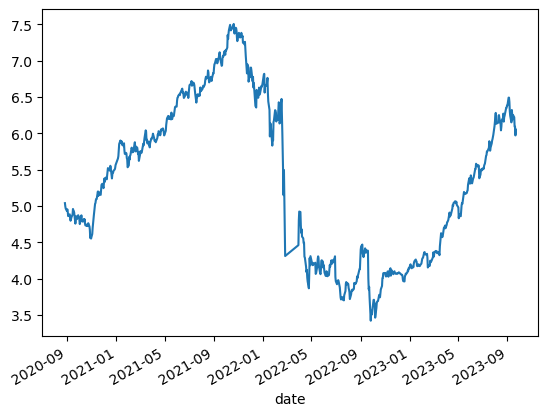

In [73]:
df.Close.plot()